In [ ]:
# default_exp gbe.wm.scoring

# Working memory task - Scoring

<div>
    <p align="left"><img src="images/wm_task.png" width = '200px'> 
        <ol style="padding-left:240px">
        <li>Participants are presented with patterns that they have to reproduce.</li>
        <li>Three trial types:
            <ul>
                <li>No distractor (this condition is duplicated)</li>
                <li>Encoding distractor (distractor shown at the same time as pattern)</li>
                <li>Delayed distractor (distractor shown after pattern disappears)</li>
            </ul>
        </li>
        <li>For each trial type, participants first complete a pattern of three.</li>
            <ul>
                <li>If they fail they move to two, if they fail again the game finishes.</li>
                <li>For each condition the level increases with success.</li>
                <li>Condition ends when two consecutive wrong or 8 trials completed (implies maximum score of 10)</li>
            </ul>
    </ol>
    
   
    
</div>

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
from trr265.gbe.wm.data_provider import WMDataProvider
import pandas as pd

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)

9 participants used an old version of the task in some of their sessions.  14 sessions (2.58%) were removed from the dataset.
6 sessions (1.14%) were removed because participants failed a level two trial.


## Example data
Here, we see example data from one participant-session in one condition.  Rows in this dataframe represent trials.  Note, how the trial-numbers are not sequential, as we extracted one condition (and conditions are mixed throughout the taks).  The variables of interest are the level and success variables.  This particular participant failed a level 3 trial.  Therefore, they went to level two and then repeated level three.  As the maximum trials per condition are 8, this means that this participant could not reach level 10, but only level 8.

In [ ]:
example = df.query("gbe_index=='b154_002' and trial_type == 'encoding_distractor'").reset_index(drop = True)
example.index += 1
example[['participant','session_number','trial_number','level','trial_type','success']]

,participant,session_number,trial_number,level,trial_type,success
1,b154,2,4,3,encoding_distractor,0
2,b154,2,7,2,encoding_distractor,1
3,b154,2,10,3,encoding_distractor,1
4,b154,2,15,4,encoding_distractor,1
5,b154,2,19,5,encoding_distractor,1
6,b154,2,21,6,encoding_distractor,1
7,b154,2,26,7,encoding_distractor,1
8,b154,2,28,8,encoding_distractor,1


## Aggregation methods

### The gold standard: Maximum WM load
The standard way of calculating WM is to calculate the maximum level reached in each condition: "Performance in each condition was measured as the maximum WM load at which a trial was answered correctly. The maximum score for each condition was 10. The score from the ND condition was used as a measure of WMC." (McNab et al., 2015, p.6518)

In [ ]:
#export
def get_max_levels(df):
    '''This function calculates max levels from wm data.'''
    # Selecting successful trials only.
    successful_trials = df.query('success==1')
    # Grouping by participant, session, and condition and getting the maximum level.
    max_levels = successful_trials.groupby(['gbe_index','trial_type'])['level'].max().unstack()
    # Labeling variables
    max_levels = max_levels[['no_distractor_1', 'no_distractor_2', 'encoding_distractor', 'delayed_distractor']]
    max_levels = max_levels.add_prefix("max_level_")
    return max_levels

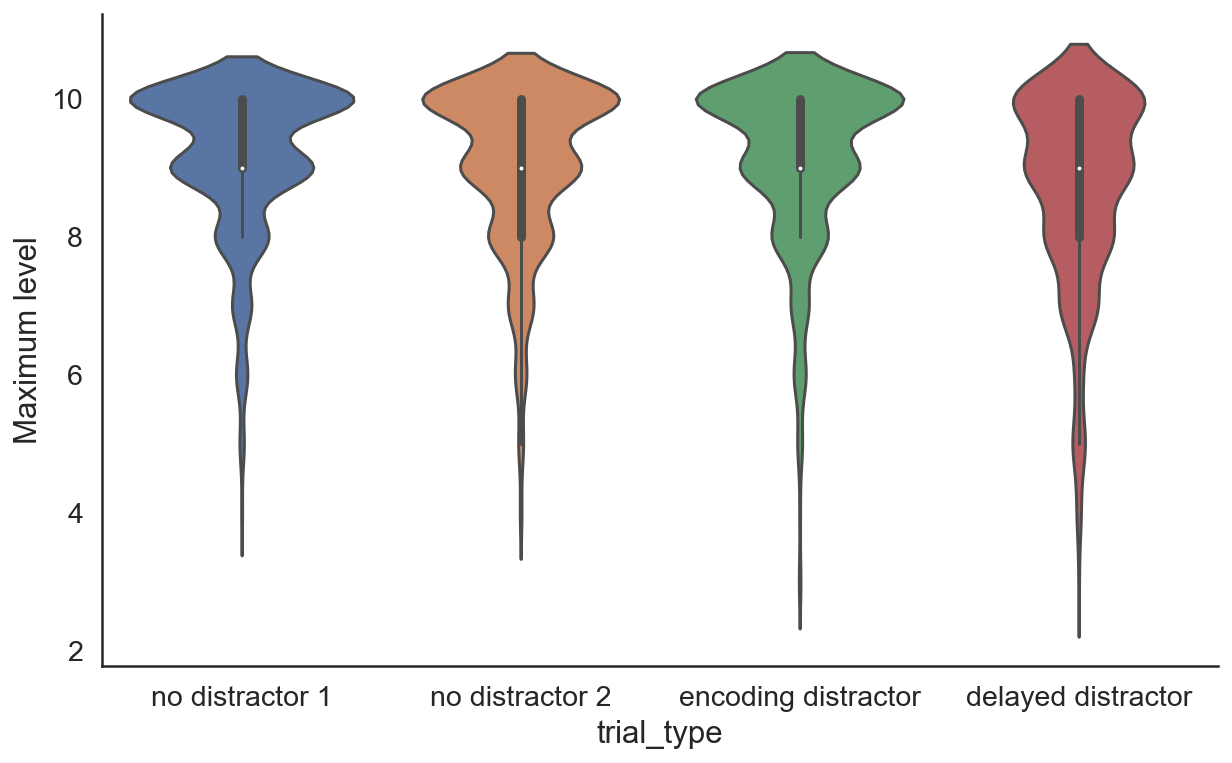

In [ ]:
max_levels = get_max_levels(df)
fix, ax = plt.subplots(figsize = (10,6))
sns.violinplot(x="trial_type", y="value", data=pd.melt(max_levels), ax = ax)
ax.set_ylabel("Maximum level")
new_ticks = [' '.join(t.get_text().split('_')[2:]) for t in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks)
sns.despine()

> Warning: Although the no_distractor_1 and no_distractor_2 conditions should be similar, it looks like they slightly differ from each other.

In [ ]:
df.groupby('trial_type').success.mean()

trial_type
delayed_distractor     0.865064
encoding_distractor    0.906576
no_distractor_1        0.909663
no_distractor_2        0.898350
Name: success, dtype: float64

> Indeed, the success rate is slightly lower in the no_distractor_2 conditions.

In [ ]:
df['timetaken'] = df.timetaken.astype(float)
df.groupby('trial_type').timetaken.mean()

trial_type
delayed_distractor     2.629614
encoding_distractor    2.554661
no_distractor_1        2.614426
no_distractor_2        3.029521
Name: timetaken, dtype: float64

> Participants also take slightly longer when completing no_distractor_2 trials.

### Percentage correct
One of the goals of this project is to analyze data on the same level on which it has been generated, which in this case is the trial level.  The maximum level reached is not suiteable for trial level analysis.  Percentage correct on the other hand are.

In [ ]:
#export
def get_perc_correct(df):
    '''This function calculates percentage correct from wm data.'''
    max_levels = df.groupby(['gbe_index','trial_type'])['success'].mean().unstack()
    max_levels = max_levels[['no_distractor_1', 'no_distractor_2', 'encoding_distractor', 'delayed_distractor']]
    max_levels = max_levels.add_prefix("perc_correct_")
    return max_levels

#### Distribution

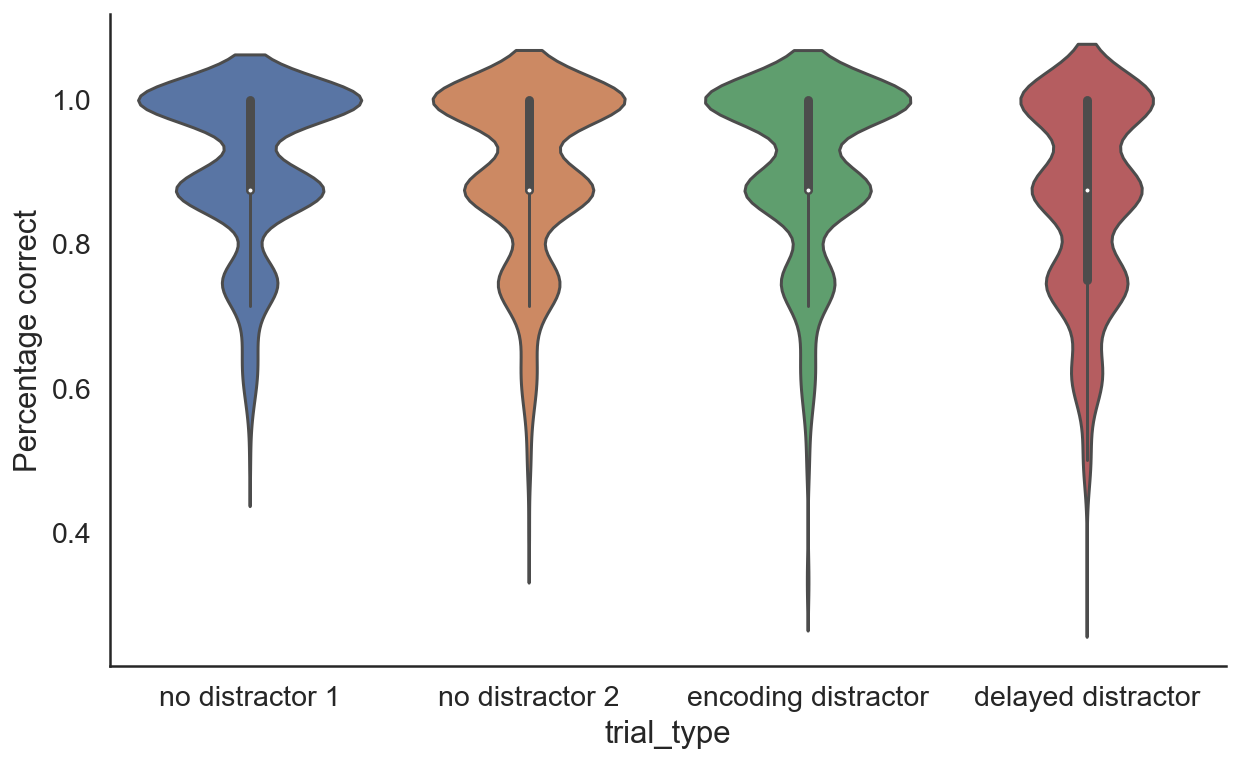

In [ ]:
perc_correct = get_perc_correct(df)
fix, ax = plt.subplots(figsize = (10,6))
sns.violinplot(x="trial_type", y="value", data=pd.melt(perc_correct), ax = ax)
ax.set_ylabel("Percentage correct")
new_ticks = [' '.join(t.get_text().split('_')[2:]) for t in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks)
sns.despine()

#### Correlation with gold standard (session level)

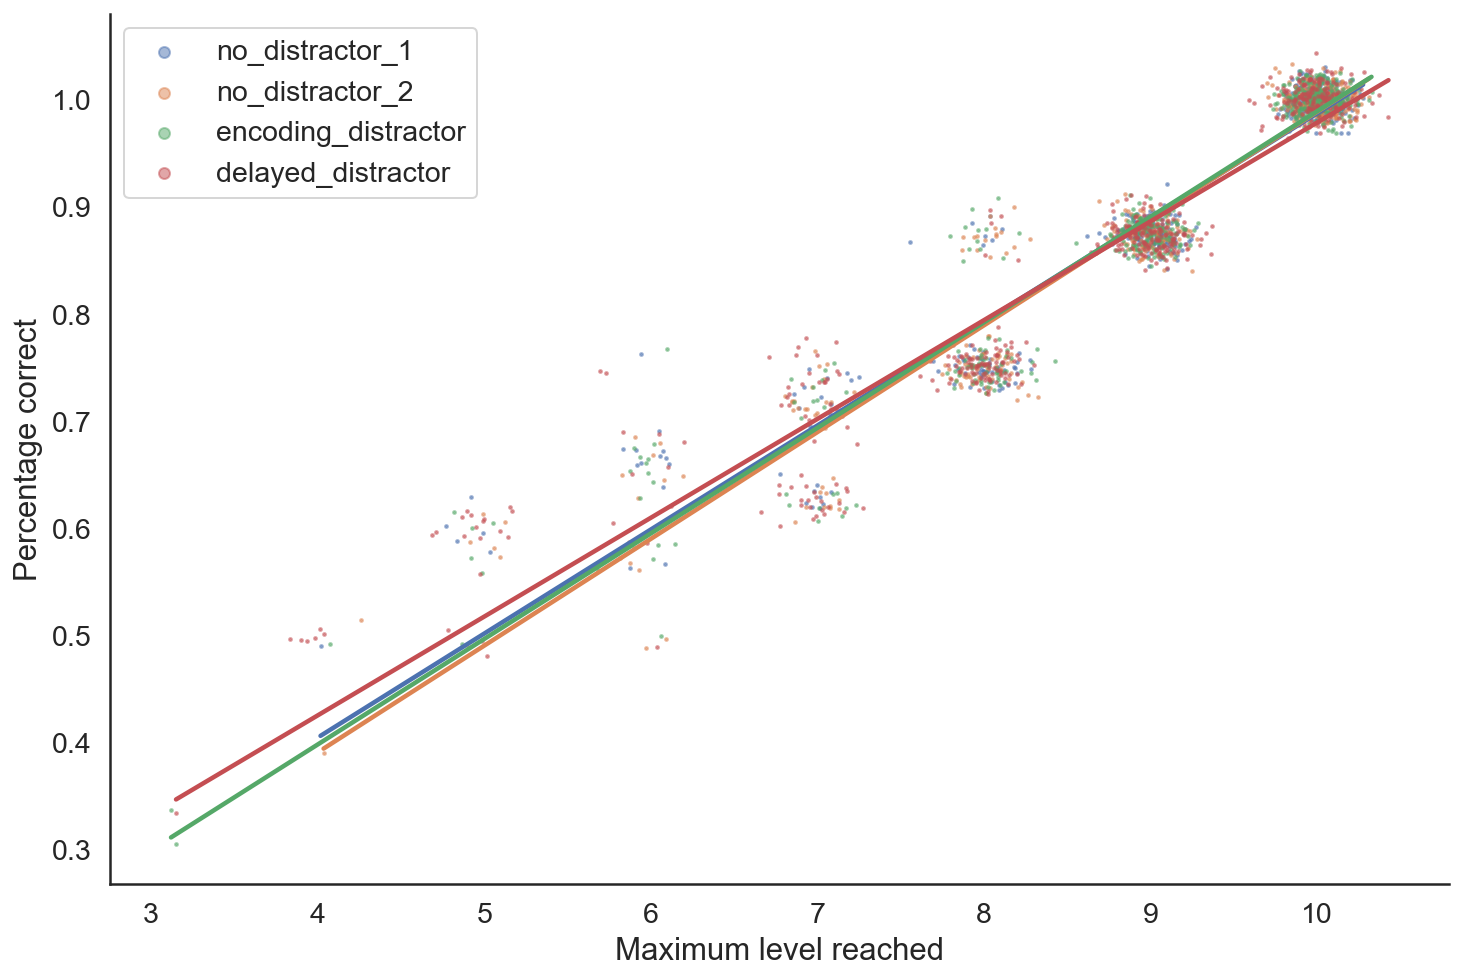

In [ ]:
import numpy as np
def jitter(arr):
    return arr + np.random.randn(len(arr)) * arr.std()/10

def jittered_regplot(**kwargs):
    df, x, y = kwargs['data'],kwargs['x'], kwargs['y']
    df[x+'_j'] = jitter(df[x])
    df[y+'_j'] = jitter(df[y])
    kwargs['x'] = x+'_j'
    kwargs['y'] = y+'_j'
    kwargs['data'] = df
    ax = sns.regplot(**kwargs)
    return ax

_df = pd.concat([max_levels, perc_correct], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
    ax = jittered_regplot(x = 'max_level_%s'%trial_type, y = 'perc_correct_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
ax.set_xlabel('Maximum level reached')
ax.set_ylabel('Percentage correct')
lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

> Percentage correct correlates quite well with maximum levels reached.  Scores under 8 do, however, not correlate perfectly.  The reason for this is that a false response at level 3 gets punished twice by the max level score, as participants are demoted to level two and then have to repeat level 3 (allowing them to only reach level 8, although they only made one mistake.

### Implied percentage correct
In finding participants maximum level, the WM task makes certain assumptions in order to keep the task short:
1. It assumes that participants are successful in level 3 would also have succeeded in level 2.
2. It assumes that participants who succeed on a level on the first try, would also have succeeded in the last try.
3. It assumes that participnats who do not reach higher levels because of the maximum trial limitation, also would not have succeeded in those levels.

In the implied percentage correct score, we make these assumptions explicit, by imputing data accordingly:

In [ ]:
def add_implied_data(df):
    # Checking whether participants needed one or two trials to complete a session
    df['duplication'] = df.groupby(['participant','session_number','trial_type','level']).cumcount()
    _df = df.set_index(['participant','session_number','trial_type','level','duplication']).sort_index()[['success']]
    # Imputing data
    levels = list(range(3,11))
    new_index = pd.MultiIndex.from_product([_df.reset_index().participant.unique(), _df.reset_index().session_number.unique(),_df.reset_index().trial_type.unique(), levels, [0,1]],names = ['participant','session_number','trial_type','level','duplication'])
    _df = _df.reindex(new_index)
    _df['implied_success'] = _df.groupby(level=['participant','session_number','trial_type','level']).transform(np.max).fillna(0)
    _df['implied_success'] = _df.success.fillna(_df.implied_success)
    _df = _df.reset_index()
    #_df['implied_success'] = _df.implied_success# * _df.level
    _df = _df.merge(df.groupby(['participant','session_number']).gbe_index.first().reset_index(), on = ['participant','session_number'], how = 'outer' )
    _df = _df[_df.gbe_index.isnull()==False]
    #implied_success = _df.groupby(['gbe_index']).implied_success.mean()
    return _df#, implied_success

#### Example

In [ ]:
add_implied_data(example)[['participant','session_number','trial_type','level','success','implied_success']]

,participant,session_number,trial_type,level,success,implied_success
0,b154,2,encoding_distractor,3,0.0,0.0
1,b154,2,encoding_distractor,3,1.0,1.0
2,b154,2,encoding_distractor,4,1.0,1.0
3,b154,2,encoding_distractor,4,NaN,1.0
4,b154,2,encoding_distractor,5,1.0,1.0
5,b154,2,encoding_distractor,5,NaN,1.0
6,b154,2,encoding_distractor,6,1.0,1.0
7,b154,2,encoding_distractor,6,NaN,1.0
8,b154,2,encoding_distractor,7,1.0,1.0
9,b154,2,encoding_distractor,7,NaN,1.0


> Note that NaN values in the old success column were imputed.  

> Warning: We removed level two data and repeated level three data.  This is a simplification, which might have to be changed at a later stage.  For now, the generated scores seem to correlate very well with maximum levels reached (see below).

In [ ]:
def get_implied_perc_correct(df):
    df = add_implied_data(df)
    '''This function calculates percentage correct from wm data.'''
    implied_perc_correct = df.groupby(['gbe_index','trial_type'])['implied_success'].mean().unstack()
    implied_perc_correct = implied_perc_correct[['no_distractor_1', 'no_distractor_2', 'encoding_distractor', 'delayed_distractor']]
    implied_perc_correct = implied_perc_correct.add_prefix("impl_perc_correct_")
    return implied_perc_correct

#### Distribution

In [ ]:
implied_perc_correct = get_implied_perc_correct(df)

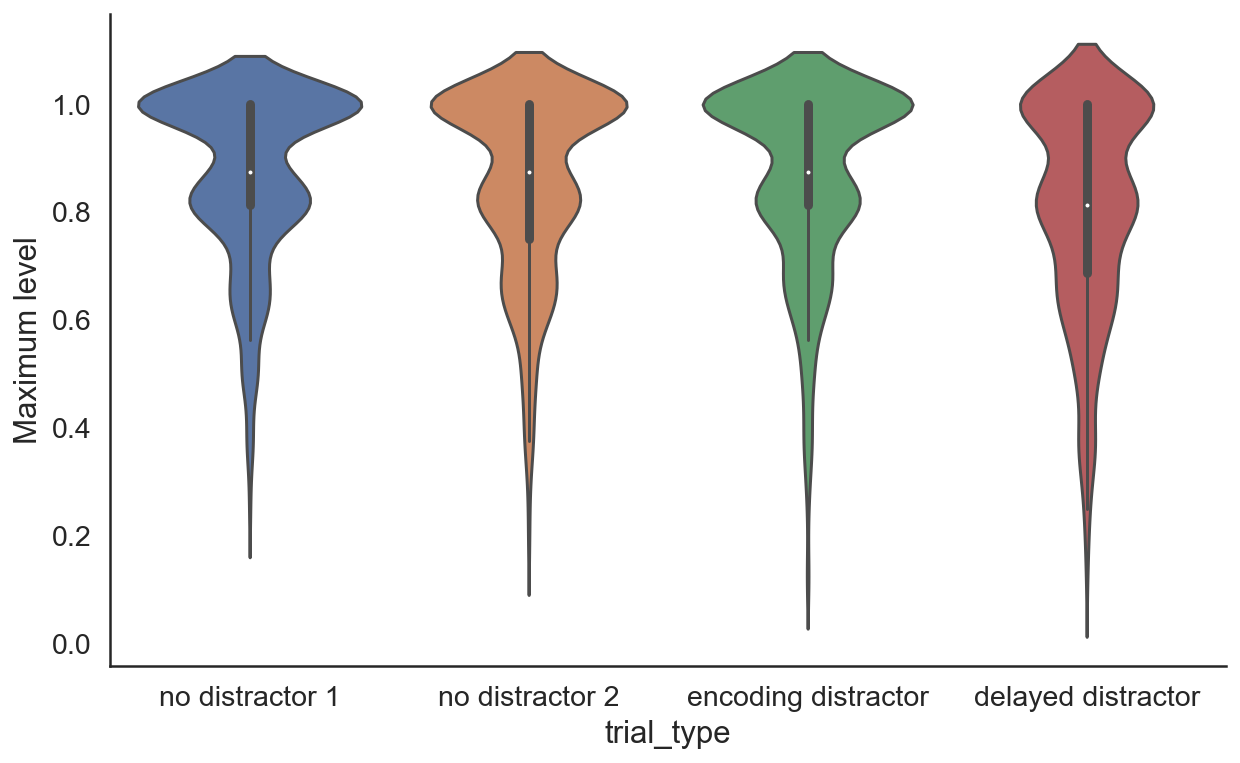

In [ ]:
fix, ax = plt.subplots(figsize = (10,6))
sns.violinplot(x="trial_type", y="value", data=pd.melt(implied_perc_correct), ax = ax)
ax.set_ylabel("Maximum level")
new_ticks = [' '.join(t.get_text().split('_')[3:]) for t in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks)
sns.despine()

#### Correlation with gold standard (session level)

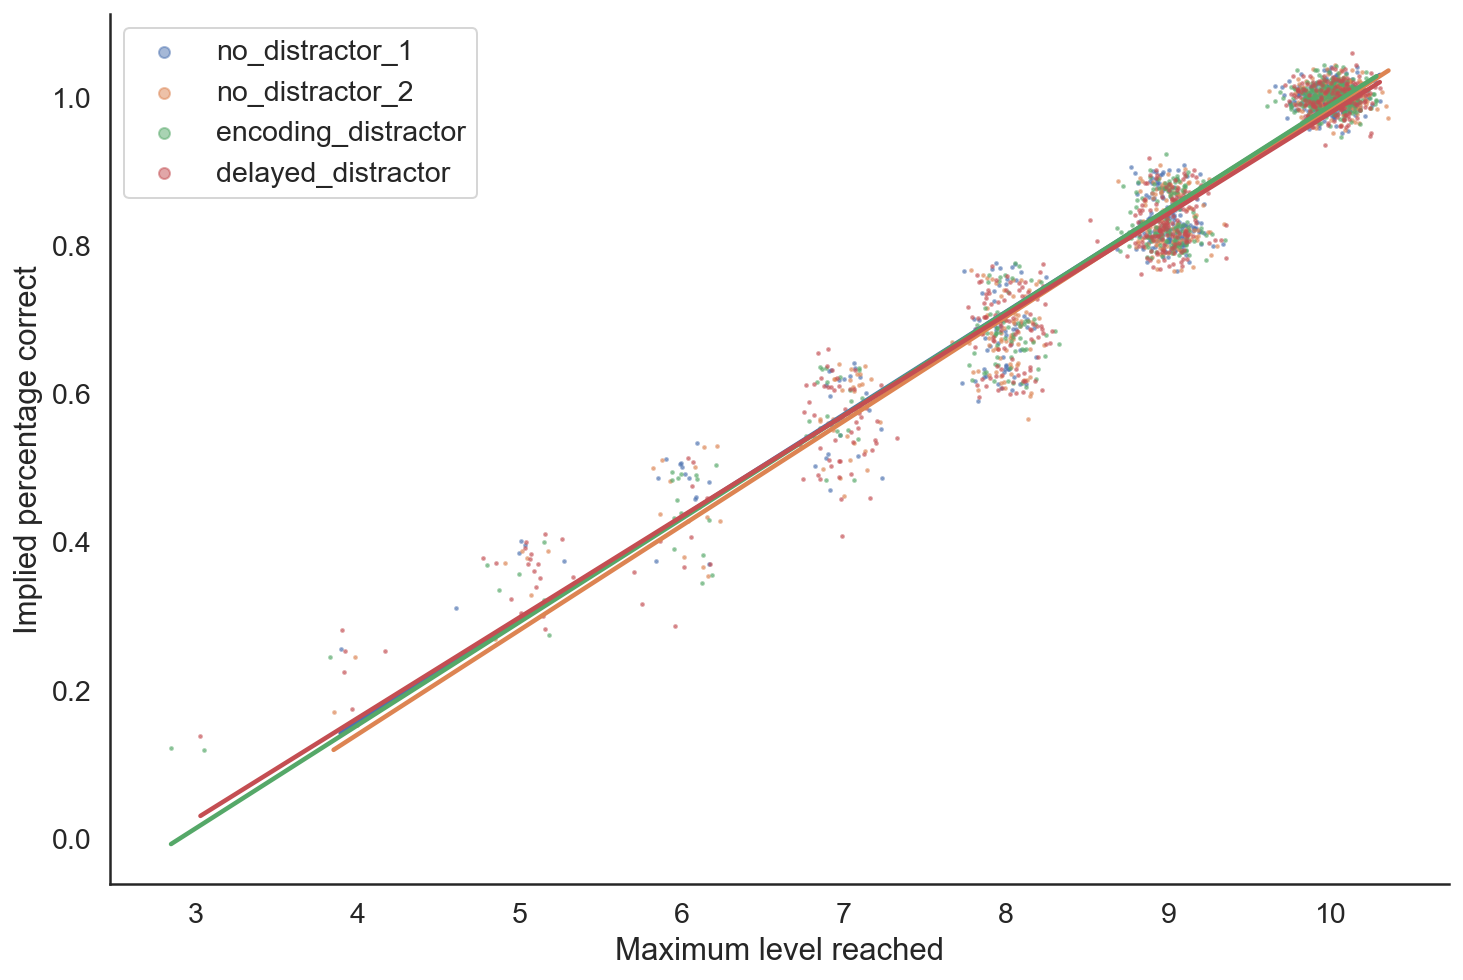

In [ ]:
_df = pd.concat([max_levels, implied_perc_correct], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
    ax = jittered_regplot(x = 'max_level_%s'%trial_type, y = 'impl_perc_correct_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
ax.set_xlabel('Maximum level reached')
ax.set_ylabel('Implied percentage correct')
lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

> Implied percentage correct correlates well with maximum levels.

## Trial level analysis
For the trial level analysis, we continue with implied percentage scores.  There are several ways in which we can model this data.

### Trial types and sessions modelled separately (check)
Here we run the model `glmer(success ~ 1 + (1 | participant)` separately for each session and trial type.  This way of modelling the data should be closely related to the aggregation method and therefore serves mostly as a check.

In [ ]:
def get_perc_correct_predicted_sep_r(df):
    %R -i df
    %R library(lmerTest)
    %R library(ggeffects)
    # Running the model
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    %R m = glmer(implied_success ~ 1 + (1 | participant), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    %R p = ggpredict(m, terms=c("participant"), type="re",ci.lvl = NA)
    %R -o p
    return p

def get_perc_correct_predicted_sep(df):
    df = add_implied_data(df)
    df = df[['implied_success','participant','session_number','trial_type']]
    
    dfs = []
    # Looping through trial types
    for trial_type in ['no_distractor_2','no_distractor_1','encoding_distractor','delayed_distractor']:
        session_dfs = []
        # Looping through sessions
        for session in [2,1]:
            # Extracting data for specific session and trial type
            _df = df.query('(session_number==@session) and (trial_type==@trial_type)')[['implied_success','participant']]
            # Predicting scores
            predicted = get_perc_correct_predicted_sep_r(_df)
            # Labeling variables
            predicted.columns = ['participant','perc_predicted_sep_%s'%trial_type,'session']
            predicted['session'] = session
            predicted['gbe_index'] = predicted.participant.astype(str) + '_%03d'%session
            predicted = predicted.set_index('gbe_index')['perc_predicted_sep_%s'%trial_type].to_frame()
    # Combining everything into one dataframe
            session_dfs.append(predicted)       
        dfs.append(pd.concat(session_dfs))
    perc_predicted_sep = pd.concat(dfs, axis = 1)     
    return perc_predicted_sep
    

perc_correct_predicted_sep = get_perc_correct_predicted_sep(df)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




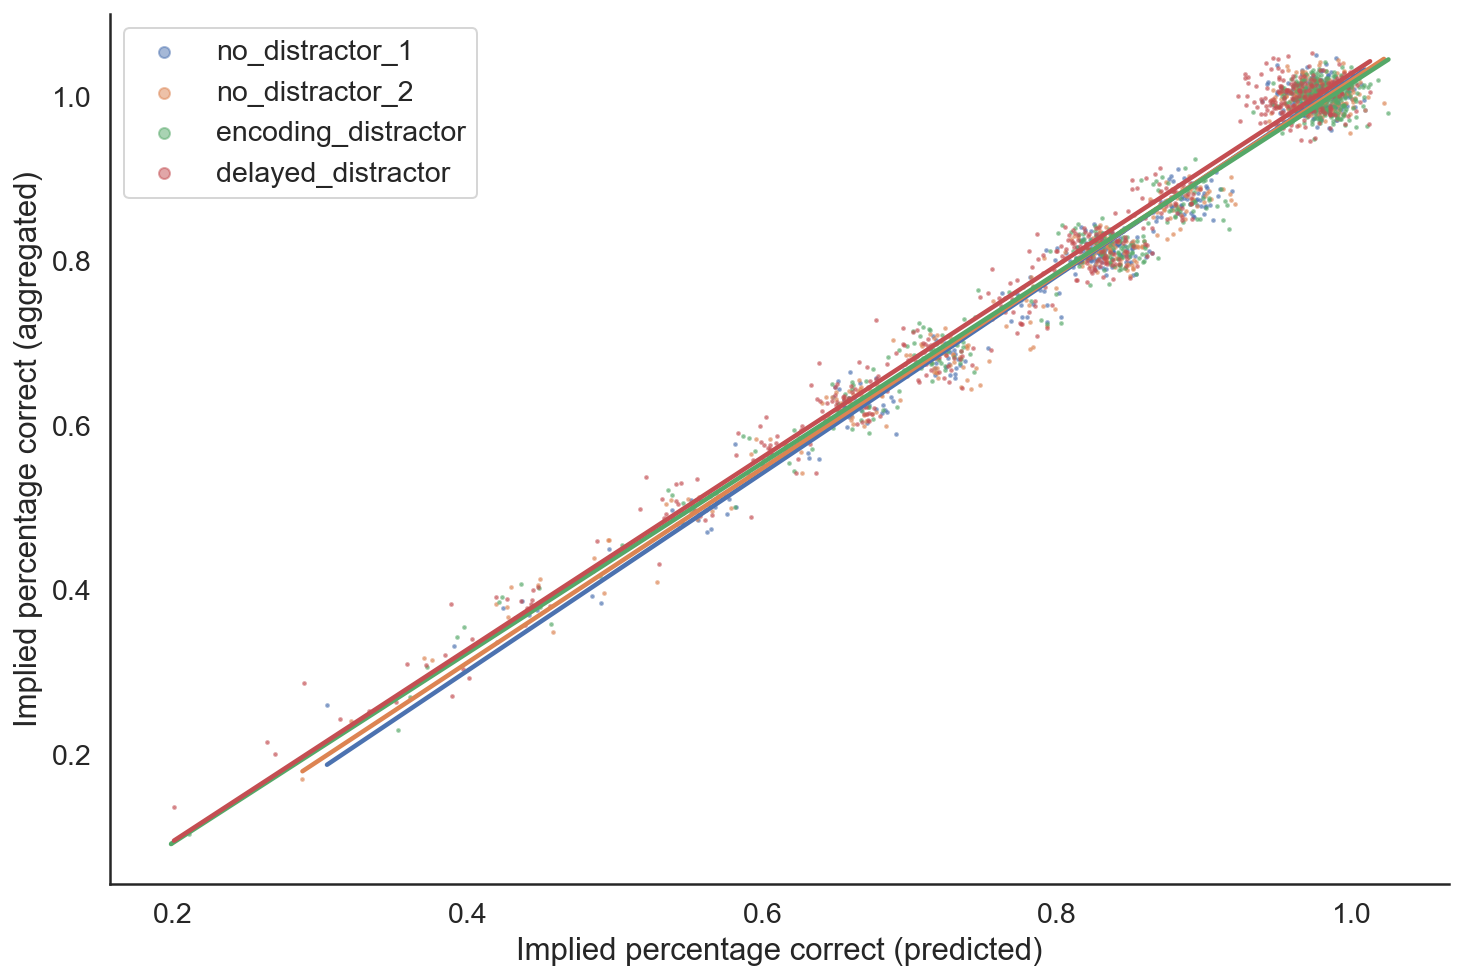

In [ ]:
_df = pd.concat([perc_correct_predicted_sep, implied_perc_correct], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
    jittered_regplot(x = 'perc_predicted_sep_%s'%trial_type, y = 'impl_perc_correct_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
ax.set_xlabel('Implied percentage correct (predicted)')
ax.set_ylabel('Implied percentage correct (aggregated)')
lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

> As expected, these scores correlate highly with aggregated scores.

### Trial types modeled separately but sessions modelled combined
Next, we run the model `glmer(success ~ 1 + (1 | participant/session)` separately for trial types but together for each session.  This model has the advantage that it integrates more data into the estimation of each session.

In [ ]:
def get_perc_correct_predicted_sep_trial_r(df):
    df = df[['implied_success','participant','session_number','trial_type']]
    df['session'] = df.session_number.astype(str) # making session a factor 
    %R -i df
    %R library(lmerTest)
    %R library(ggeffects)
    # Running the model
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    %R m = glmer(implied_success ~ 1 + (1 | participant/session), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    %R p = ggpredict(m, terms=c("participant","session"), type="re",ci.lvl = NA)
    %R -o p
    
    return p

_df = get_perc_correct_predicted_sep_trial_r(add_implied_data(df).head(8000))

_df.columns = ['participant', 'perc_predicted_sep_trial', 'session']
_df

,participant,perc_predicted_sep_trial,session
1,b001,0.911366,1
2,b001,0.931306,2
3,b002,0.986366,1
4,b002,0.981075,2
5,b012,0.891600,1
...,...,...,...
136,b147,0.981075,2
137,b152,0.893587,1
138,b152,0.904357,2
139,b153,0.986366,1


In [ ]:
def get_perc_correct_predicted_sep_trial_r(df):
    %R -i df
    %R library(lmerTest)
    %R library(ggeffects)
    # Running the model
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    %R m = glmer(implied_success ~ 1 + (1 | participant/session), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    %R p = ggpredict(m, terms=c("participant","session"), type="re",ci.lvl = NA)
    %R -o p
    return p

def get_perc_correct_predicted_sep_trial(df):
    df = add_implied_data(df)
    
    dfs = []
    # Looping through trial types
    for trial_type in ['no_distractor_2','no_distractor_1','encoding_distractor','delayed_distractor']:
        # Extracting data for specific trial type
        _df = df.query('(trial_type==@trial_type)')[['implied_success','participant','session_number']]
        _df['session'] = _df.session_number.astype(str) # making session a factor 
        # Predicting scores
        predicted = get_perc_correct_predicted_sep_trial_r(_df)
        # Labeling variables
        predicted.columns = ['participant','perc_predicted_sep_trial_%s'%trial_type,'session']
        #predicted['session'] = session
        predicted['gbe_index'] = predicted.participant.astype(str) + predicted.session.apply(lambda x: '_%03d'%int(x)).astype(str)
        predicted = predicted.set_index('gbe_index')['perc_predicted_sep_trial_%s'%trial_type].to_frame()
    # Combining everything into one dataframe
        dfs.append(predicted)
    perc_predicted_sep = pd.concat(dfs, axis = 1)     
    return perc_predicted_sep
    

In [ ]:
perc_correct_predicted_sep_trial = get_perc_correct_predicted_sep_trial(df)

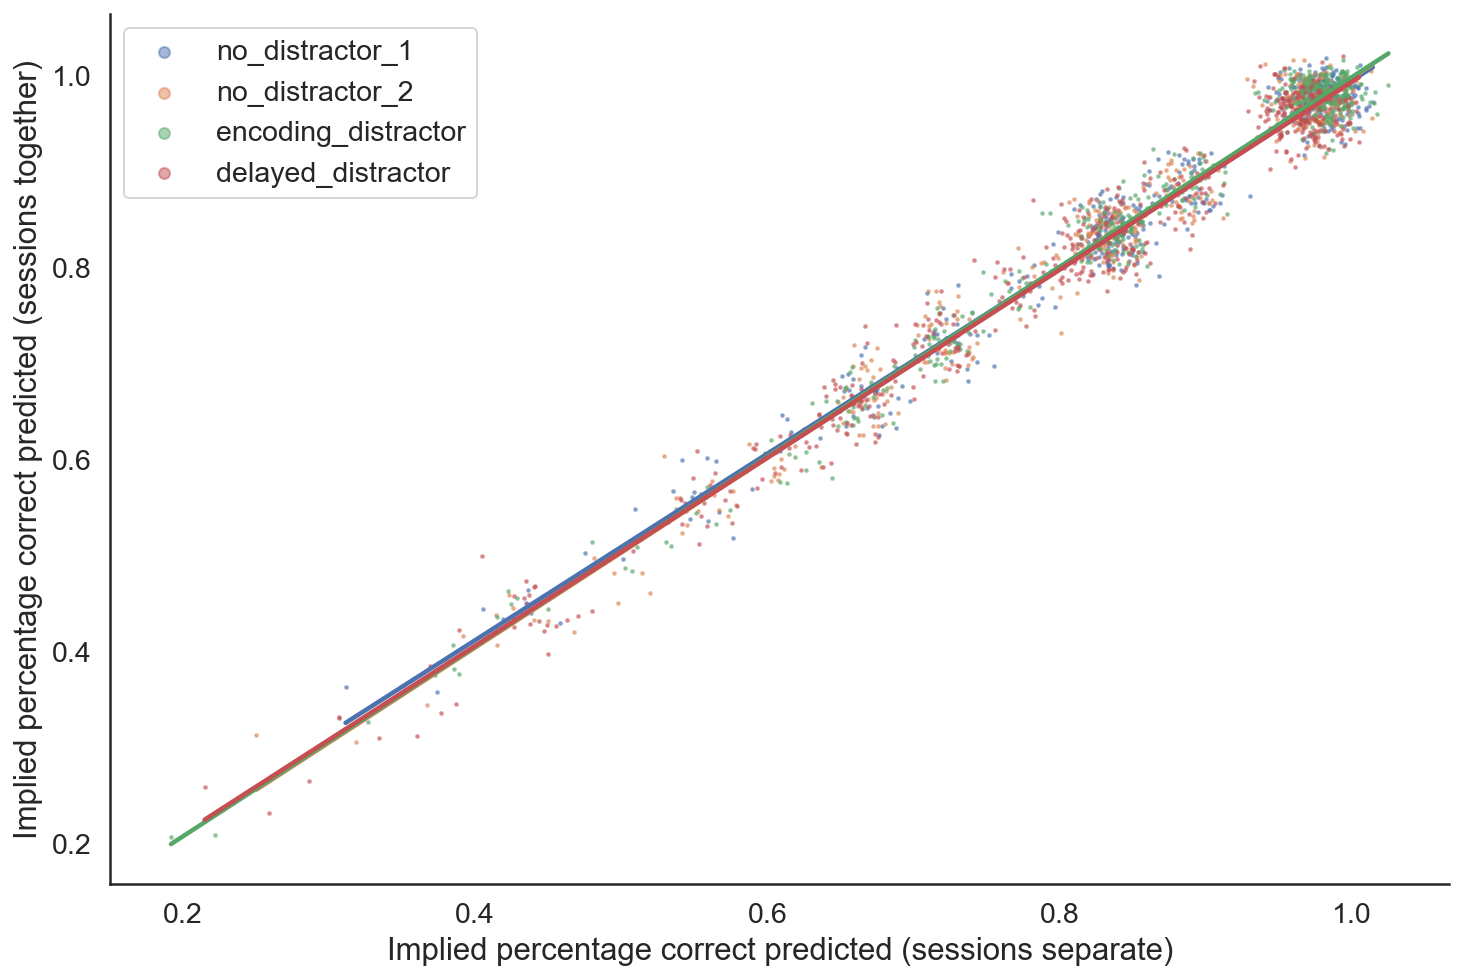

In [ ]:
_df = pd.concat([perc_correct_predicted_sep, perc_correct_predicted_sep_trial], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
    jittered_regplot(x = 'perc_predicted_sep_%s'%trial_type, y = 'perc_predicted_sep_trial_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
ax.set_xlabel('Implied percentage correct predicted (sessions separate)')
ax.set_ylabel('Implied percentage correct predicted (sessions together)')
lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

In [ ]:
def get_perc_correct_predicted_joint_r(df):
    %R -i df
    %R library(lmerTest)
    %R library(ggeffects)
    # Running the model
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    %R m = glmer(implied_success ~ 1 + trial_type + (1 + trial_type | participant/session), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    %R p = ggpredict(m, terms=c("participant","session","trial_type"), type="re",ci.lvl = NA)
    %R p = as.data.frame(p)
    %R -o p
    return p

def fix_r_frame(df):
    new_columns = []
    new_column_names = [c[0] for c in df.columns]
    for column in new_column_names:
        new_columns.append([x[0] for x in df[column].values])
    df = pd.DataFrame(new_columns).T
    df.columns = new_column_names
    return df


def get_perc_correct_predicted_joint(df):
    _df = add_implied_data(df)
    _df['session'] = _df.session_number.astype(str) # making session a factor 
    _df = _df[['participant','session_number','session','trial_type','implied_success']]
    predicted = get_perc_correct_predicted_joint_r(_df)
    predicted.columns = [['participant','predicted_perc_correct_joint','session','trial_type']]
    # Fixing R dtypes
    predicted = fix_r_frame(predicted)
    predicted['gbe_index'] = predicted.participant.astype(str) + predicted.session.apply(lambda x: '_%03d'%int(x)).astype(str)
    predicted = predicted.set_index(['gbe_index','trial_type']).unstack()['predicted_perc_correct_joint']
    predicted = predicted.add_prefix("perc_predicted_joint_")
    return predicted

In [ ]:
perc_correct_predicted_joint = get_perc_correct_predicted_joint(df)

R[write to console]: boundary (singular) fit: see ?isSingular



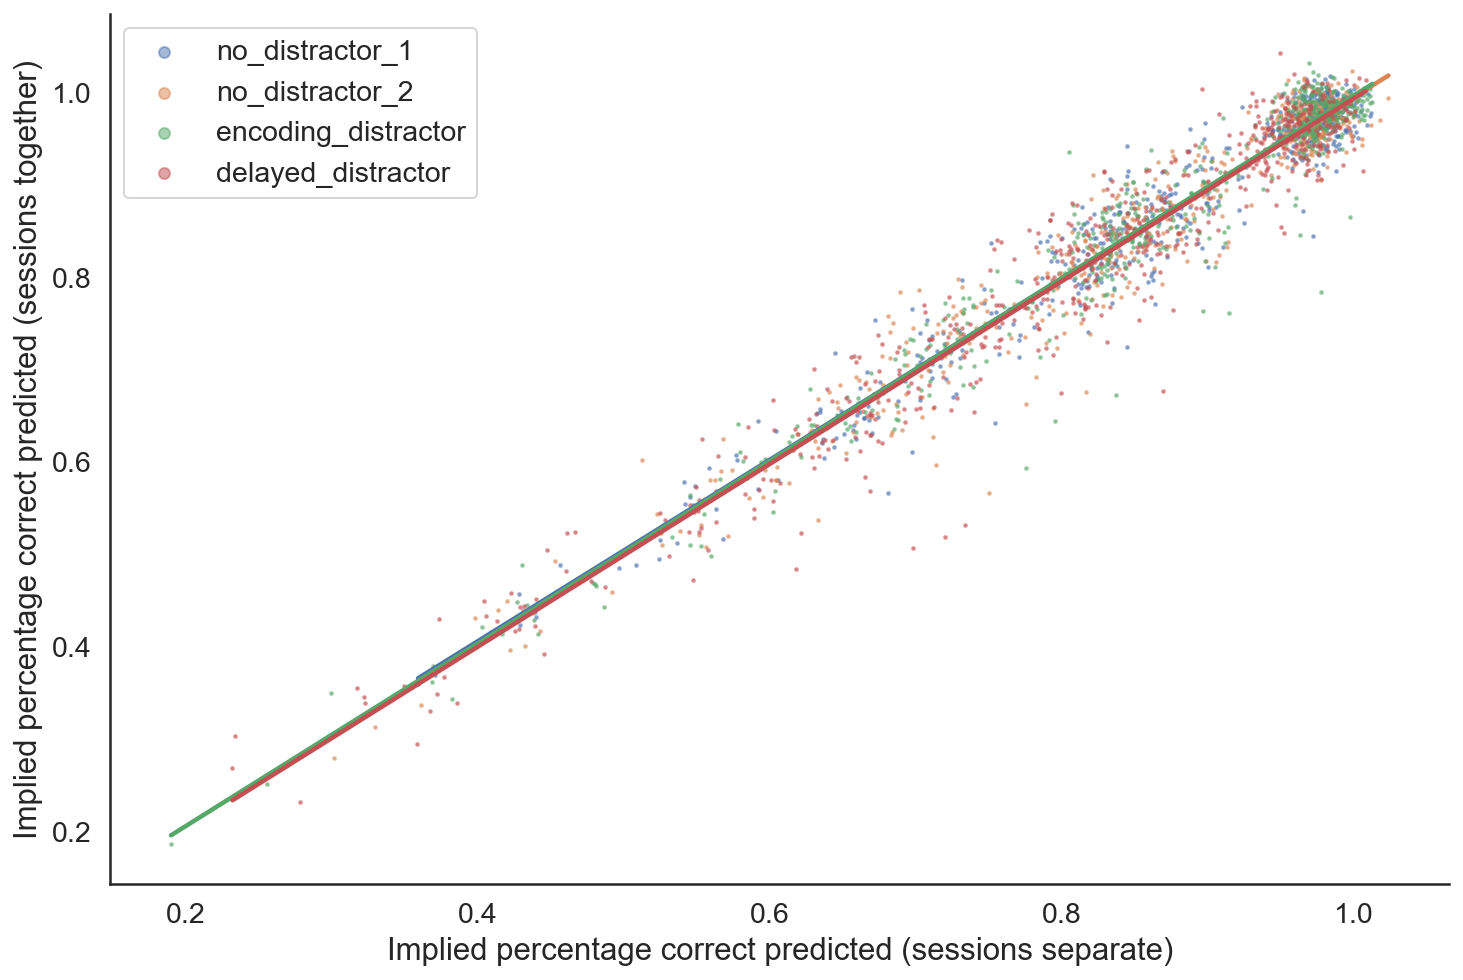

In [ ]:
_df = pd.concat([perc_correct_predicted_joint, perc_correct_predicted_sep_trial], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
    jittered_regplot(x = 'perc_predicted_sep_trial_%s'%trial_type, y = 'perc_predicted_joint_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
ax.set_xlabel('Implied percentage correct predicted (sessions separate)')
ax.set_ylabel('Implied percentage correct predicted (sessions together)')
lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

R[write to console]: boundary (singular) fit: see ?isSingular



no_distractor_1
no_distractor_2
encoding_distractor
delayed_distractor


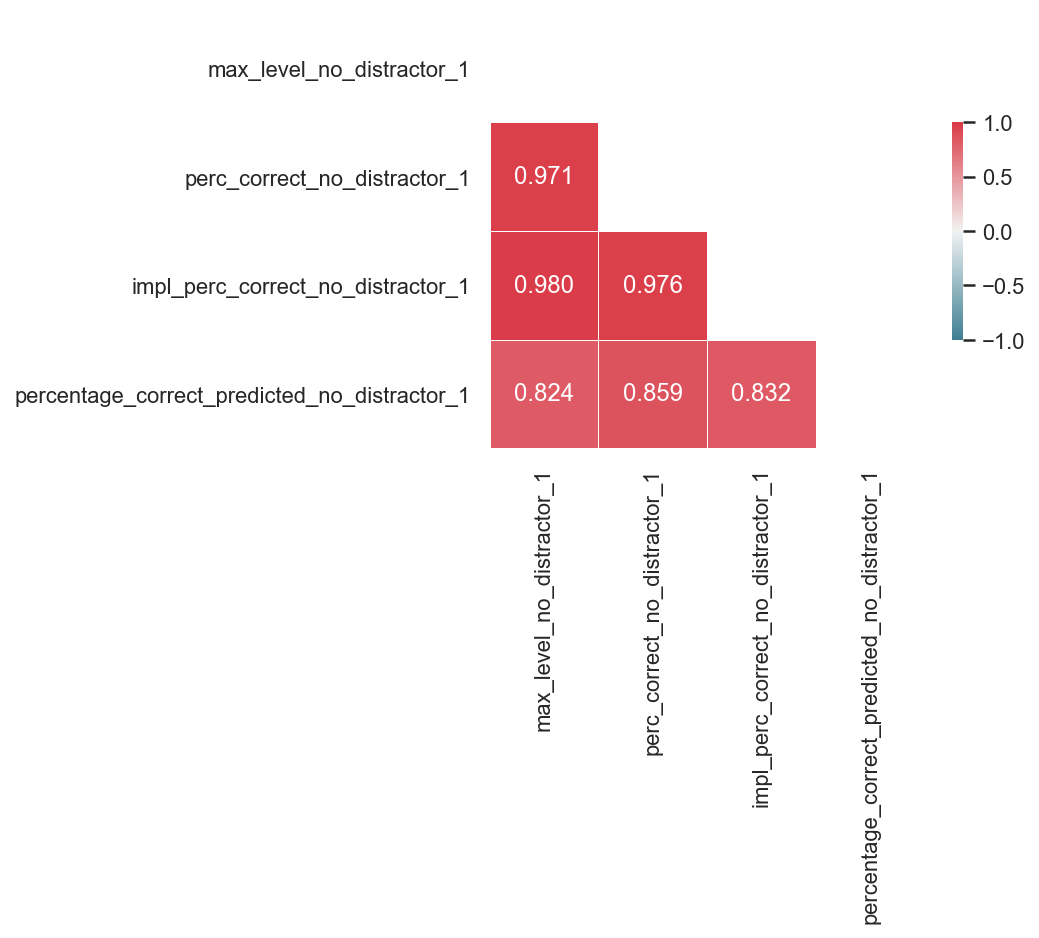

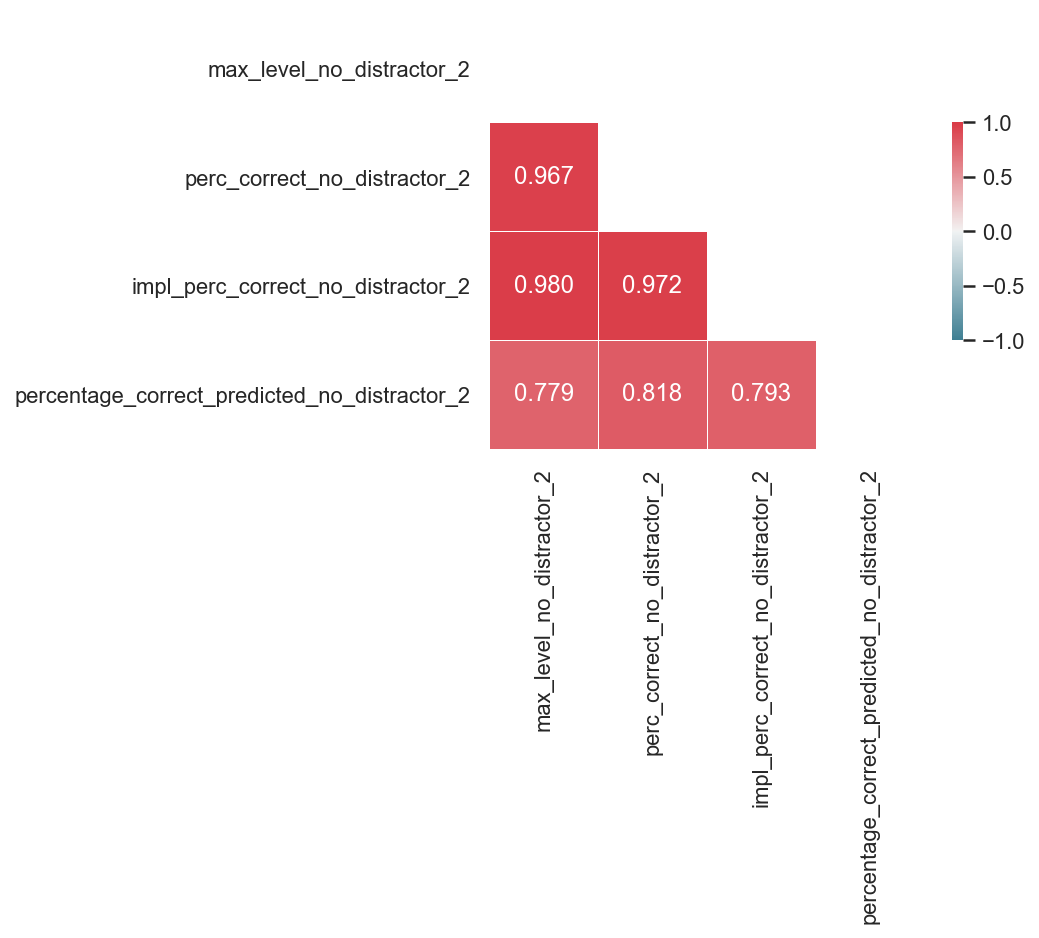

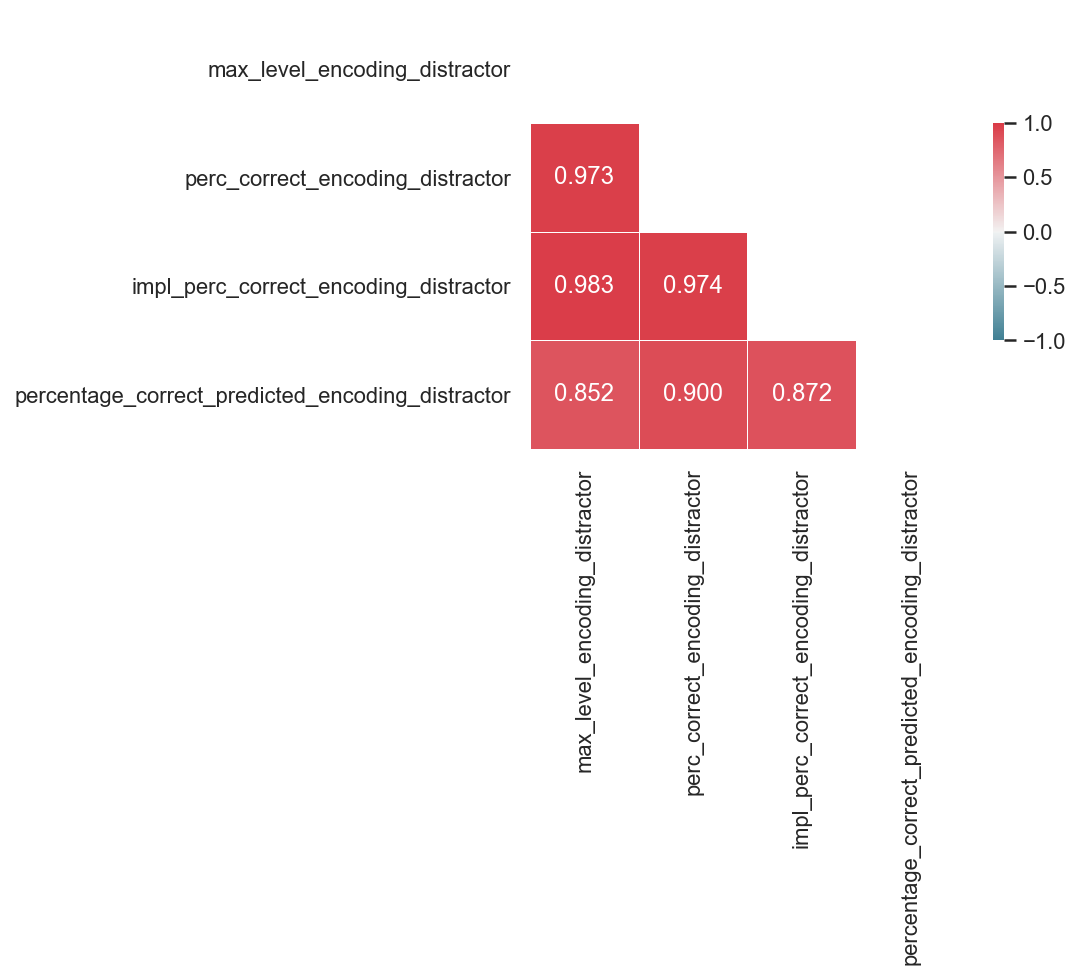

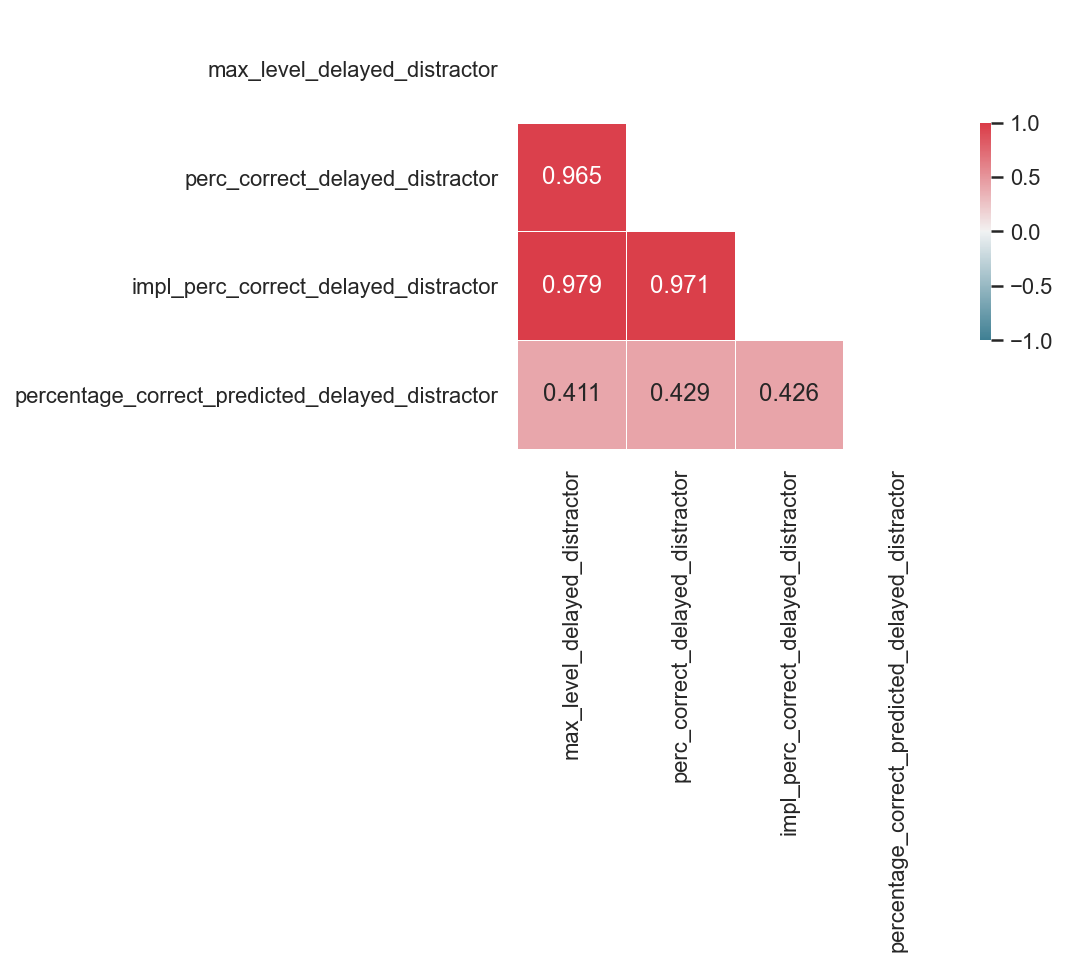

In [ ]:
def show_correlations():
    df = get_max_levels().merge(get_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_implied_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_percentage_correct_predicted(), left_index = True, right_index = True)
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        print(trial_type)
        type_columns =[c for c in df.columns if trial_type in c]
        plotting.correlation_matrix(df[type_columns], size = (5,4))
show_correlations()

In [ ]:
def display_correlation():
    df = get_max_levels().merge(get_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_implied_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_percentage_correct_predicted(), left_index = True, right_index = True)
    correlation_matrix(df, size = (15,12))

# ToDO

## Get stan to run

In [ ]:
def get_condition_percentage_correct_predicted_bayesian(df):
    s1 = df.query('baseline_session == "Session 1"')
    display(s1)
    s2 = df.query('baseline_session == "Session 2"')
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))  #mixed logistic regression
    %R library(rstanarm)
    %R m1 = stan_glmer(success ~ 1 + (1 | participant), data=s1, family=binomial, na.action = na.exclude) -i s1
    %R m2 = stan_glmer(success ~ 1 + (1 | participant), data=s2, family=binomial, na.action = na.exclude) -i s2
    %R p1 <- ggpredict(m1, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p1
    %R p2 <- ggpredict(m2, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p2
    p1.columns = ['participant','predicted','baseline_session']
    p2.columns = ['participant','predicted','baseline_session']
    p1['baseline_session'] = 'Session 1'
    p2['baseline_session'] = 'Session 2'
    predicted = pd.concat([p1,p2], ignore_index = True)
    # This line is ugly (all it does is bring the data back to the gbe_baseline_index)
    predicted = pd.merge(predicted, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted

def get_percentage_correct_predicted_bayesian():
    df = wm_data_getter()
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    r_data = df[['gbe_baseline_index','participant','baseline_session','type','success']]
    r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))

    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = r_data.query('type=="%s"'%trial_type)
        session_data['percentage_correct_predicted_%s'%trial_type] = get_condition_percentage_correct_predicted_bayesian(type_data)
    return session_data

def describe_predicted_perc_correct_distribution_bayesian():
    perc_correct = get_percentage_correct_predicted()
    sns.violinplot(x="variable", y="value", data=pd.melt(perc_correct))
    for column in perc_correct.columns:
        (perc_correct[column]*100).utils.describe(description = 'The percentage correct in the "%s"'%' '.join(column.split('_')[2:]), unit = "percent")
    
      
#describe_predicted_perc_correct_distribution_bayesian()